In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 


# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }


plt.rcParams.update(params)
plt.rc('text', usetex=True)

"""
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
"""
# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)

In [24]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "energy": [], "standard_error":[],"standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error = np.mean(standard_errors_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["energy"].append(mean_energy_alpha)
        data_dict["standard_error"].append(standard_error)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe


## Grid search $\alpha$ without interactions

In [4]:
N = 50
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_10 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler_NI = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**16)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_NI_N10 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions = safe_initial_positions_no_interactions(wf,
                                                               alpha,
                                                               N,
                                                               dim)
                                                   
    result = sampler_NI.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=4,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=5000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-7,
                            optimize=False
                           )
    results_NI_N10.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Warm done
Warm done
Warm done
Tune done
Tune done
Tune done
Warm after tune done
Sampling energy
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Tune done
Warm done
Warm after tune done
Sampling energy
Warm done
Warm done
Tune done
Tune done
Warm after tune done
Sampling energy
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Tune done
Warm done
Tune done
Warm doneWarm after tune done

Sampling energy
Warm after tune done
Sampling energy
Warm done
Tune done
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Tune doneWarm done

Warm done
Warm doneWarm after tune done

Sampling energy
Tune done
Tune done
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Warm done
Tune done
Tune done
Warm done
Warm after tune done
Sampling energy
W

In [29]:
N=50
df_NI_N50 = pd.concat(results_NI_N10, ignore_index=True)
#mod_df_NI_50 = df_N50
df_means_NI_N50 = get_mean_w_standard_error_grid_search(df_NI_N50, alphas)
df_means_NI_N50["energy"] = df_means_NI_N50["energy"]/N
df_means_NI_N50["standard_error"] = df_means_NI_N50["standard_error"]/N
df_means_NI_N50["standard_error_of_the_mean"] = df_means_NI_N50["standard_error_of_the_mean"]/N
df_means_NI_N50

,alpha,energy,standard_error,standard_error_of_the_mean
0,0.1,3.740381,0.142950,0.013654
1,0.2,2.152189,0.065954,0.003613
2,0.3,1.717376,0.036036,0.003411
3,0.4,1.531747,0.014374,0.002159
4,0.5,1.500000,0.000000,0.000000
5,0.6,1.529559,0.009185,0.000976
6,0.7,1.592584,0.020986,0.002081
7,0.8,1.682939,0.026738,0.002325
8,0.9,1.767687,0.031061,0.003530
9,1.0,1.894175,0.032505,0.003463


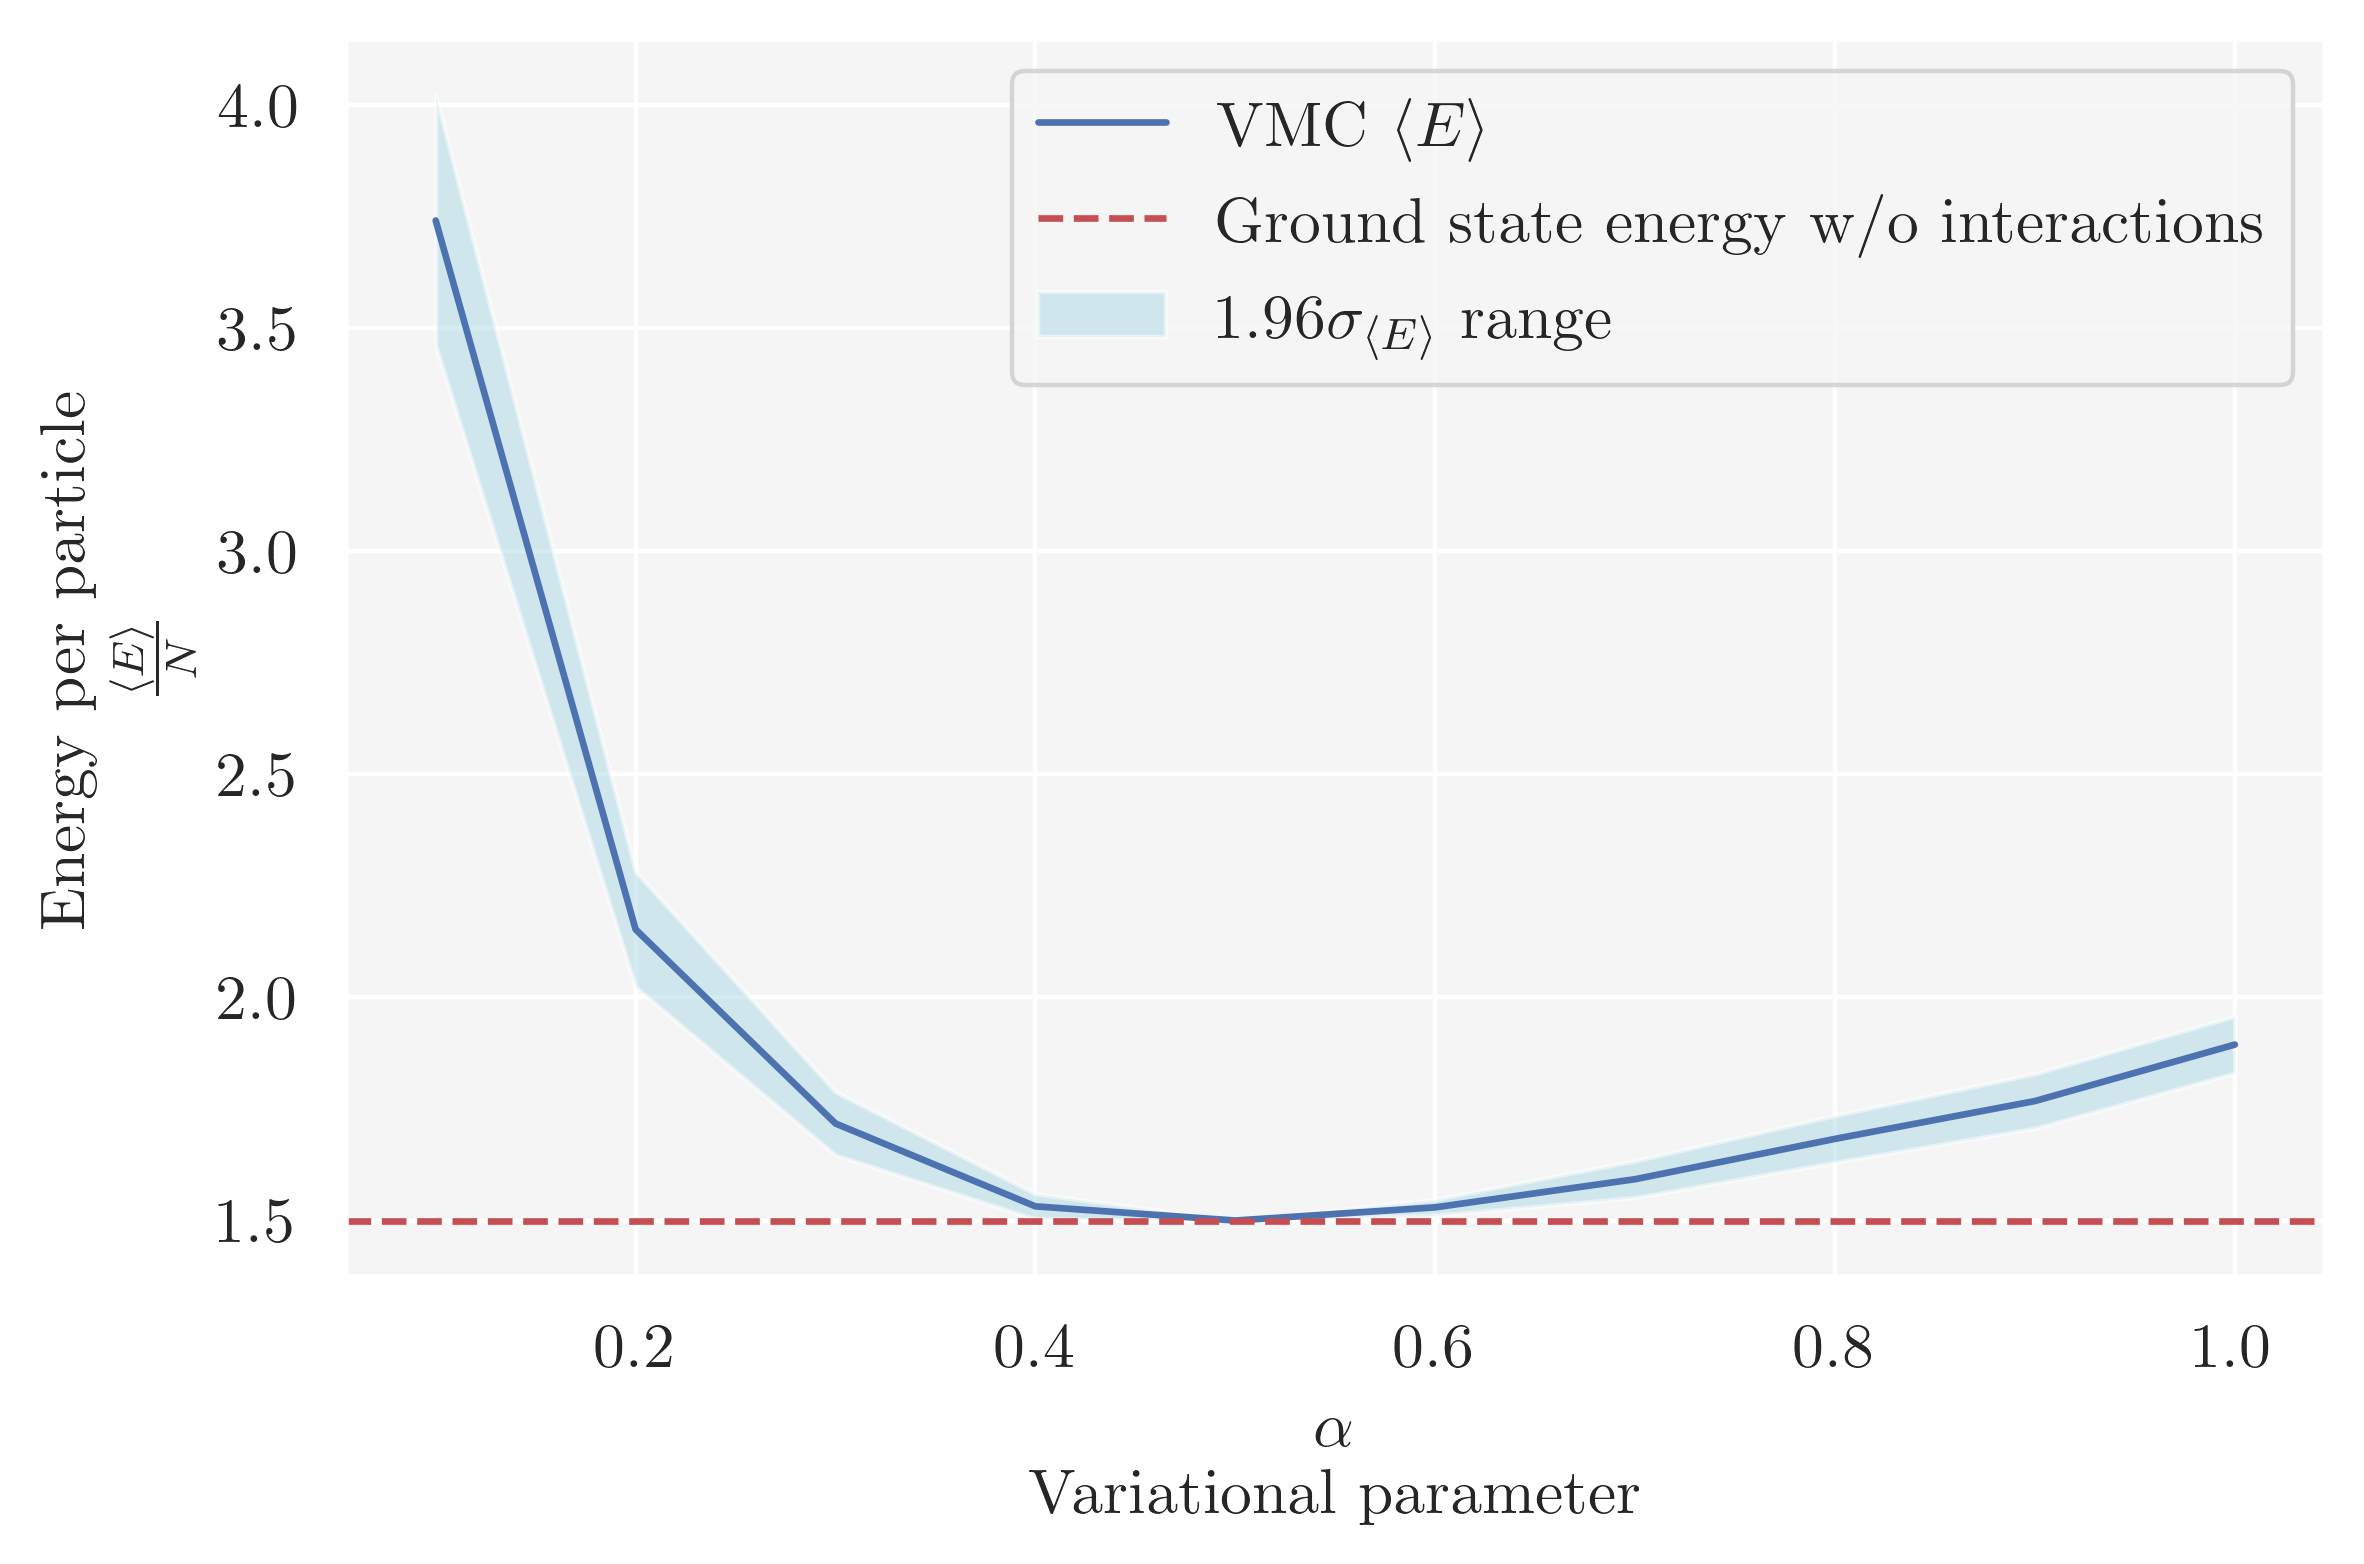

In [30]:
lower_bound = df_means_NI_N50["energy"] - 1.96*df_means_NI_N50["standard_error"]
upper_bound = df_means_NI_N50["energy"] + 1.96*df_means_NI_N50["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_NI_N50, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_NI_N50["alpha"], lower_bound, upper_bound, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_wo_interactions_N_50.pdf"), bbox_inches='tight')

## Grid search $\alpha$ with interactions

In [7]:
N = 10
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_10 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**16)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_I_N10 = []
distance_dict = {"alpha": alphas, "distances": []}

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=2, #bytt til 8
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=5000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-7,
                            optimize=False
                           )
    distance_dict["distances"].append(sampler.distance_samples[0])
    results_I_N10.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Warm done
Tune done
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm doneWarm done

Tune done
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Warm done
Tune done
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Warm done
Tune done
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Warm done
Tune done
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Warm done
Tune done
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Warm done
Tune done
Warm after tune done
Sampling energy
Tune done
Warm after tune done
Sampling energy
Warm done
Warm done
Tune done
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Warm done
Tune done
Tune done
Warm after tune done
Sampling energy
Warm after 

In [31]:
N=10
df_N10 = pd.concat(results_I_N10, ignore_index=True)
df_means_N10 = get_mean_w_standard_error_grid_search(df_N10, alphas)
df_means_N10["energy"] = df_means_N10["energy"]/N
df_means_N10["standard_error"] = df_means_N10["standard_error"]/N
df_means_N10["standard_error_of_the_mean"] = df_means_N10["standard_error_of_the_mean"]/N
df_means_N10

,alpha,energy,standard_error,standard_error_of_the_mean
0,0.1,4.038949,0.076580,0.001198
1,0.2,2.200061,0.027846,0.001504
2,0.3,1.718528,0.015574,0.001359
3,0.4,1.546942,0.005267,0.000407
4,0.5,1.524221,0.000115,0.000003
5,0.6,1.559834,0.007612,0.001860
6,0.7,1.613993,0.014584,0.003238
7,0.8,1.686914,0.019837,0.004948
8,0.9,1.829738,0.021609,0.003285
9,1.0,1.943939,0.027944,0.002796


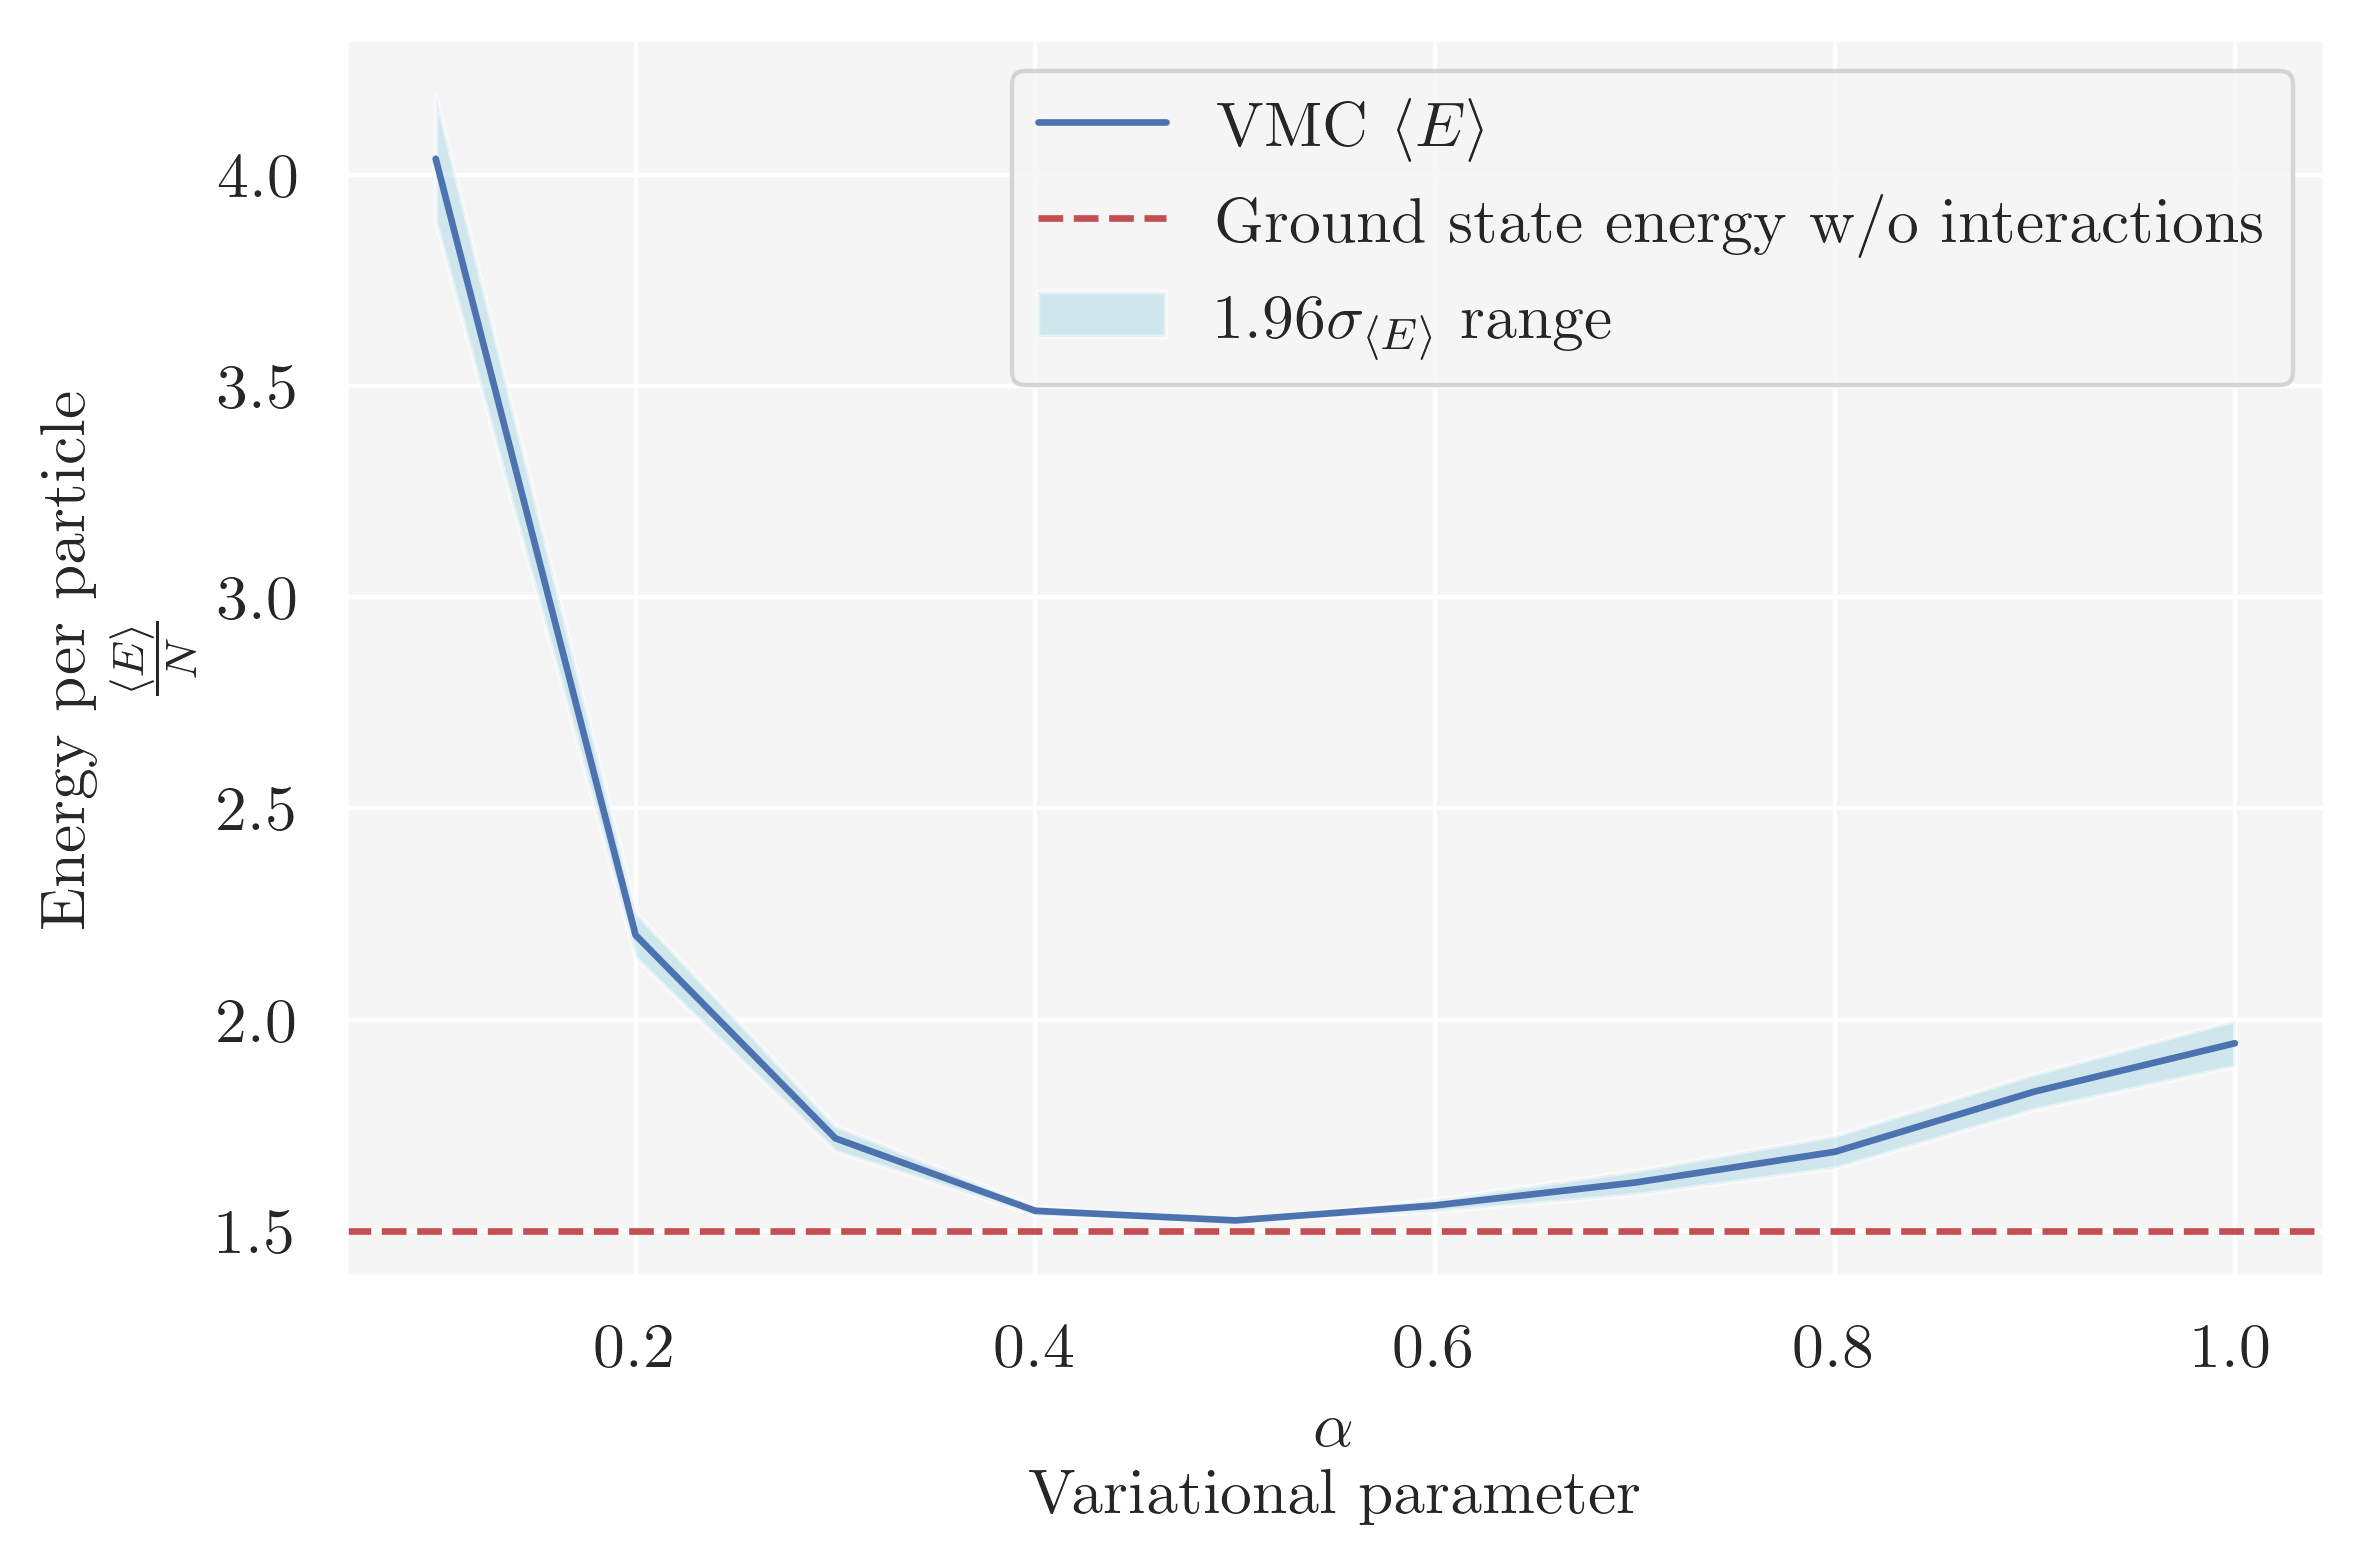

In [32]:
lower_bound_N10 = df_means_N10["energy"] - 1.96*df_means_N10["standard_error"]
upper_bound_N10 = df_means_N10["energy"] + 1.96*df_means_N10["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_N10, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_N10["alpha"], lower_bound_N10, upper_bound_N10, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_10.pdf"), bbox_inches='tight')

In [10]:
N = 50
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_50 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**16)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_N50 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1, #bytt til 8
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=10000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results_N50.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 1246.909613609314


In [33]:
N=50
df_N50 = pd.concat(results_N50, ignore_index=True)
df_means_N50 = get_mean_w_standard_error_grid_search(df_N50, alphas)
df_means_N50["energy"] = df_means_N50["energy"]/N
df_means_N50["standard_error"] = df_means_N50["standard_error"]/N
df_means_N50["standard_error_of_the_mean"] = df_means_N50["standard_error_of_the_mean"]/N
df_means_N50

,alpha,energy,standard_error,standard_error_of_the_mean
0,0.1,3.991152,0.262032,0.0
1,0.2,2.332635,0.043100,0.0
2,0.3,1.729864,0.022942,0.0
3,0.4,1.620084,0.014352,0.0
4,0.5,1.600925,0.000282,0.0
5,0.6,1.638441,0.012051,0.0
6,0.7,1.766995,0.016932,0.0
7,0.8,1.842323,0.024198,0.0
8,0.9,1.915540,0.035414,0.0
9,1.0,2.023191,0.049460,0.0


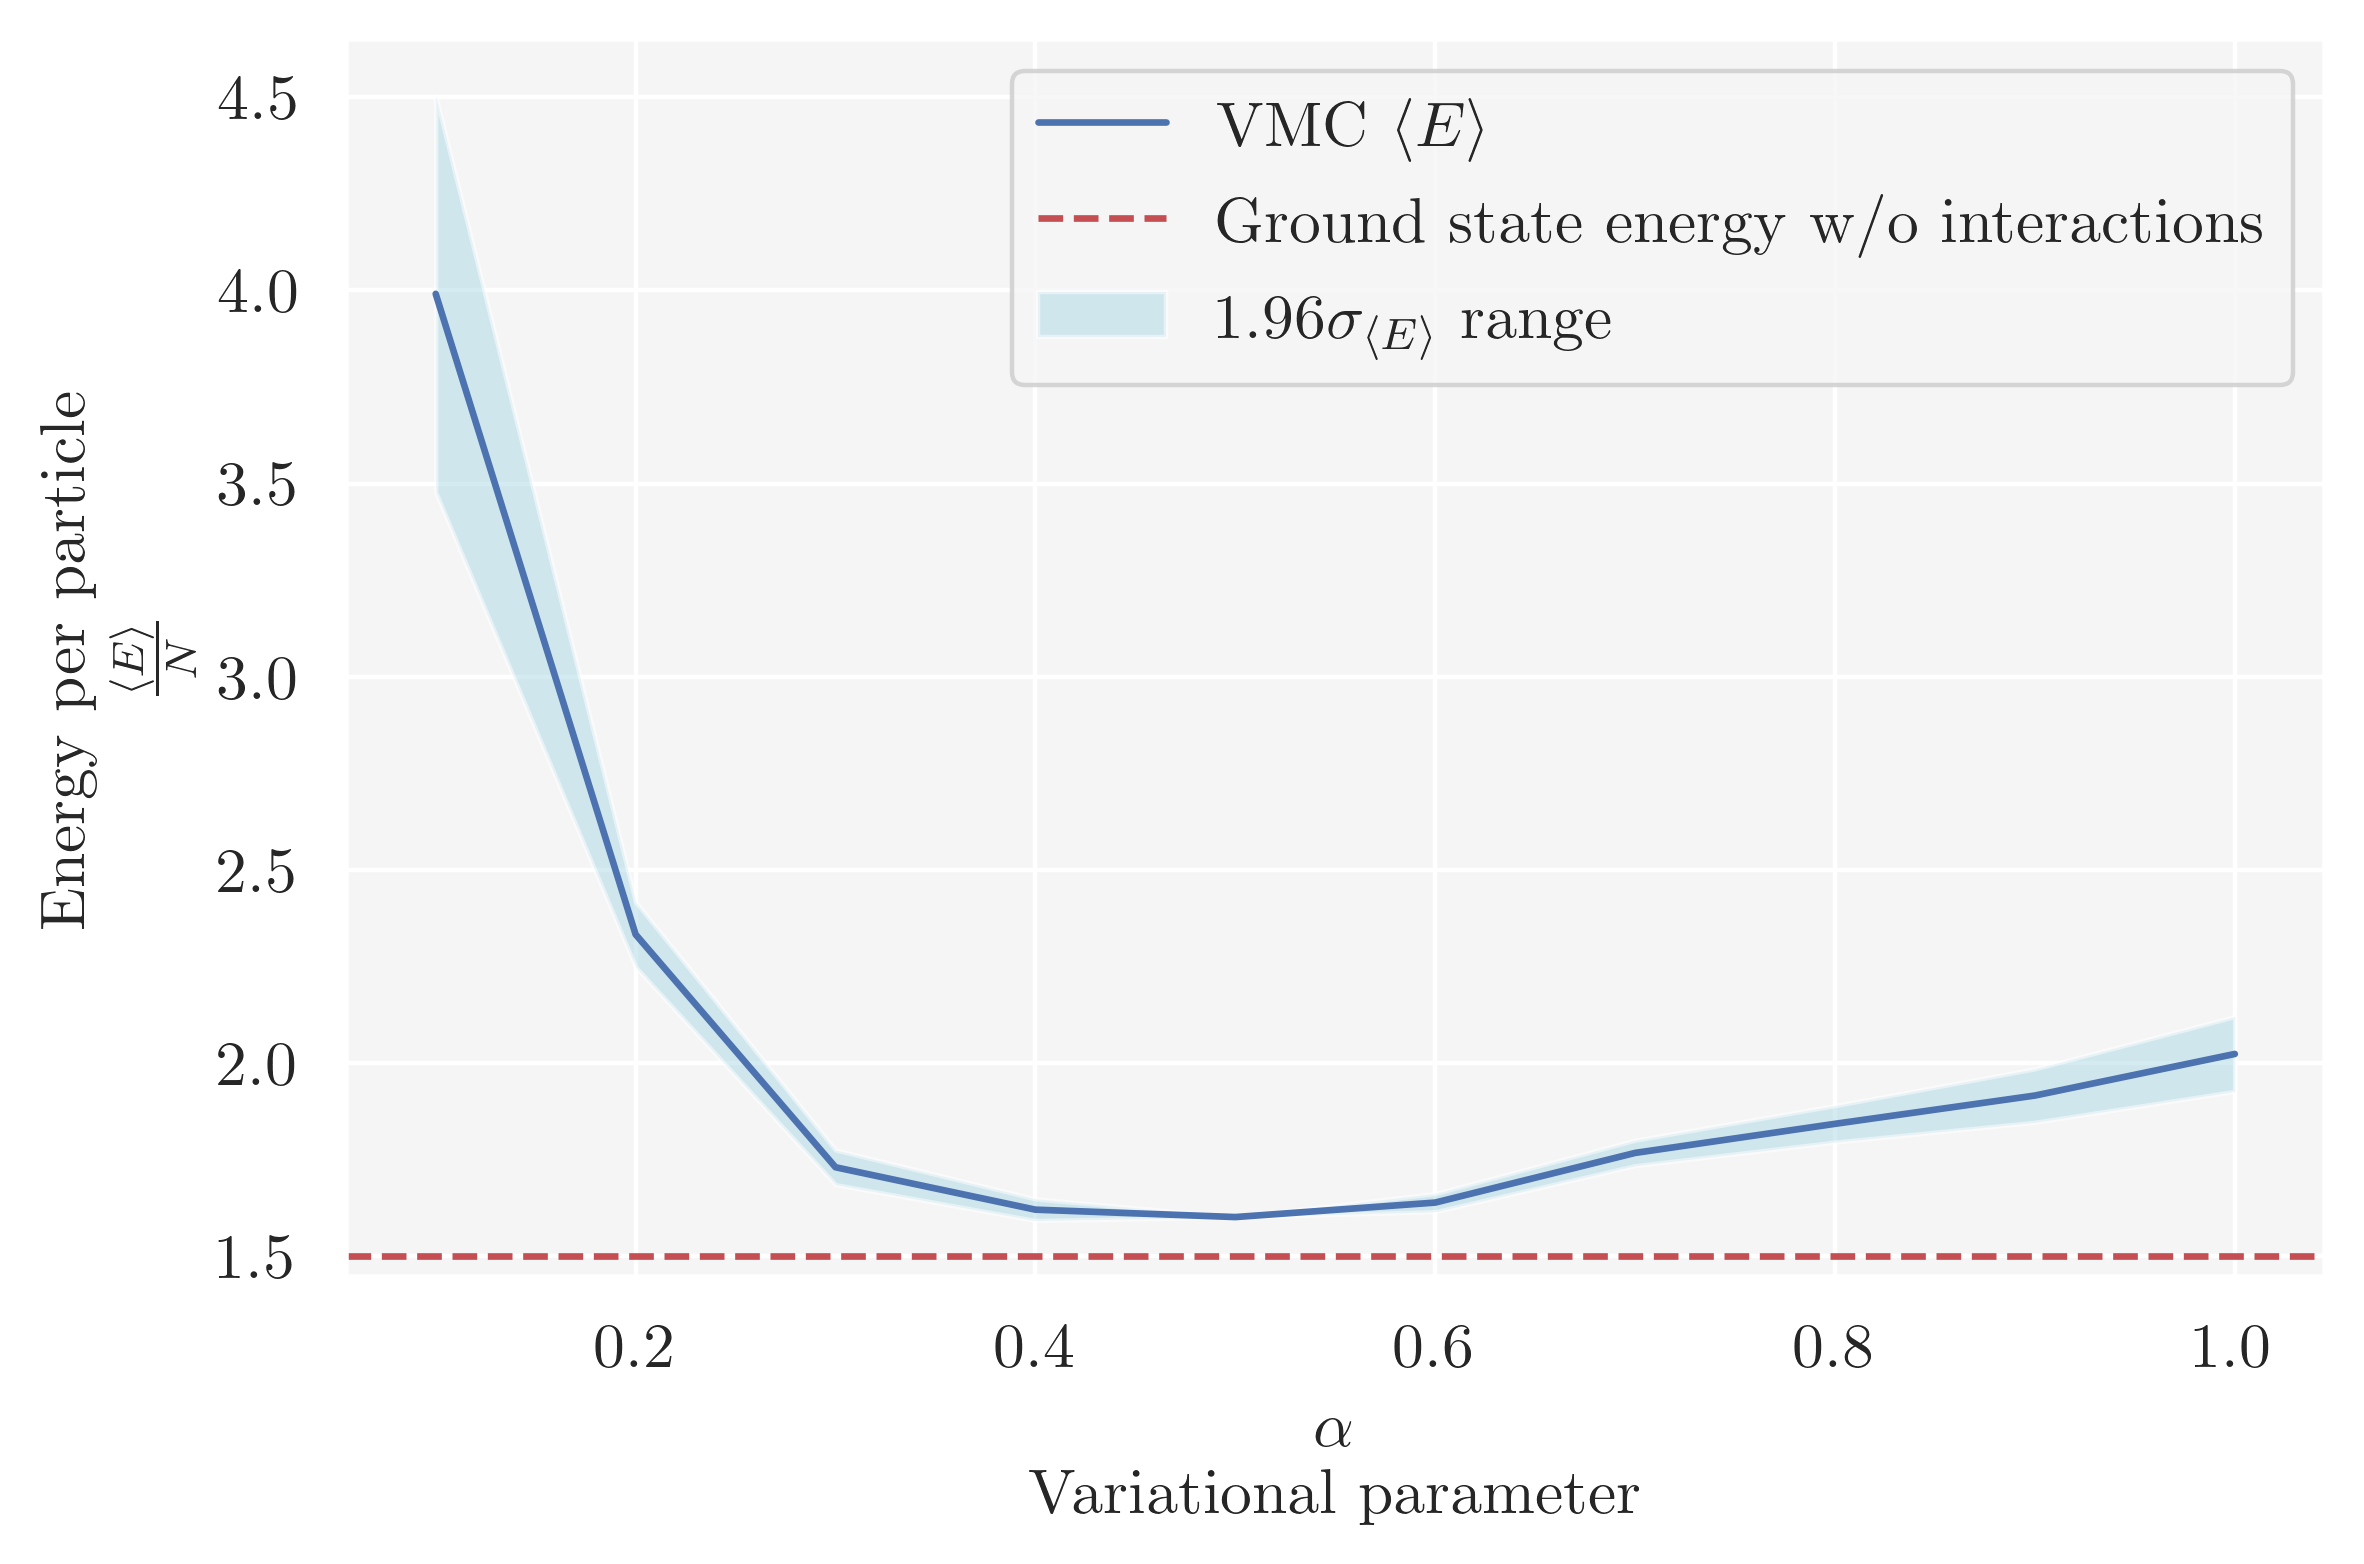

In [34]:
lower_bound_N50 = df_means_N50["energy"] - 1.96*df_means_N50["standard_error"]
upper_bound_N50 = df_means_N50["energy"] + 1.96*df_means_N50["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_N50, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_N50["alpha"], lower_bound_N50, upper_bound_N50, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_50.pdf"), bbox_inches='tight')

In [13]:
N = 100
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_100 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_N100 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1, #bytt til 8
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=15000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results_N100.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 6014.867585897446


In [35]:
N=100
df_N100 = pd.concat(results_N100, ignore_index=True)
df_means_N100 = get_mean_w_standard_error_grid_search(df_N100, alphas)
df_means_N100["energy"] = df_means_N100["energy"]/N
df_means_N100["standard_error"] = df_means_N100["standard_error"]/N
df_means_N100["standard_error_of_the_mean"] = df_means_N100["standard_error_of_the_mean"]/N
df_means_N100

,alpha,energy,standard_error,standard_error_of_the_mean
0,0.1,4.224687,0.153955,0.0
1,0.2,2.450950,0.149222,0.0
2,0.3,1.864340,0.030642,0.0
3,0.4,1.693892,0.010323,0.0
4,0.5,1.681690,0.000325,0.0
5,0.6,1.714605,0.010381,0.0
6,0.7,1.777970,0.020070,0.0
7,0.8,1.927849,0.024913,0.0
8,0.9,2.037743,0.032926,0.0
9,1.0,2.165053,0.036500,0.0


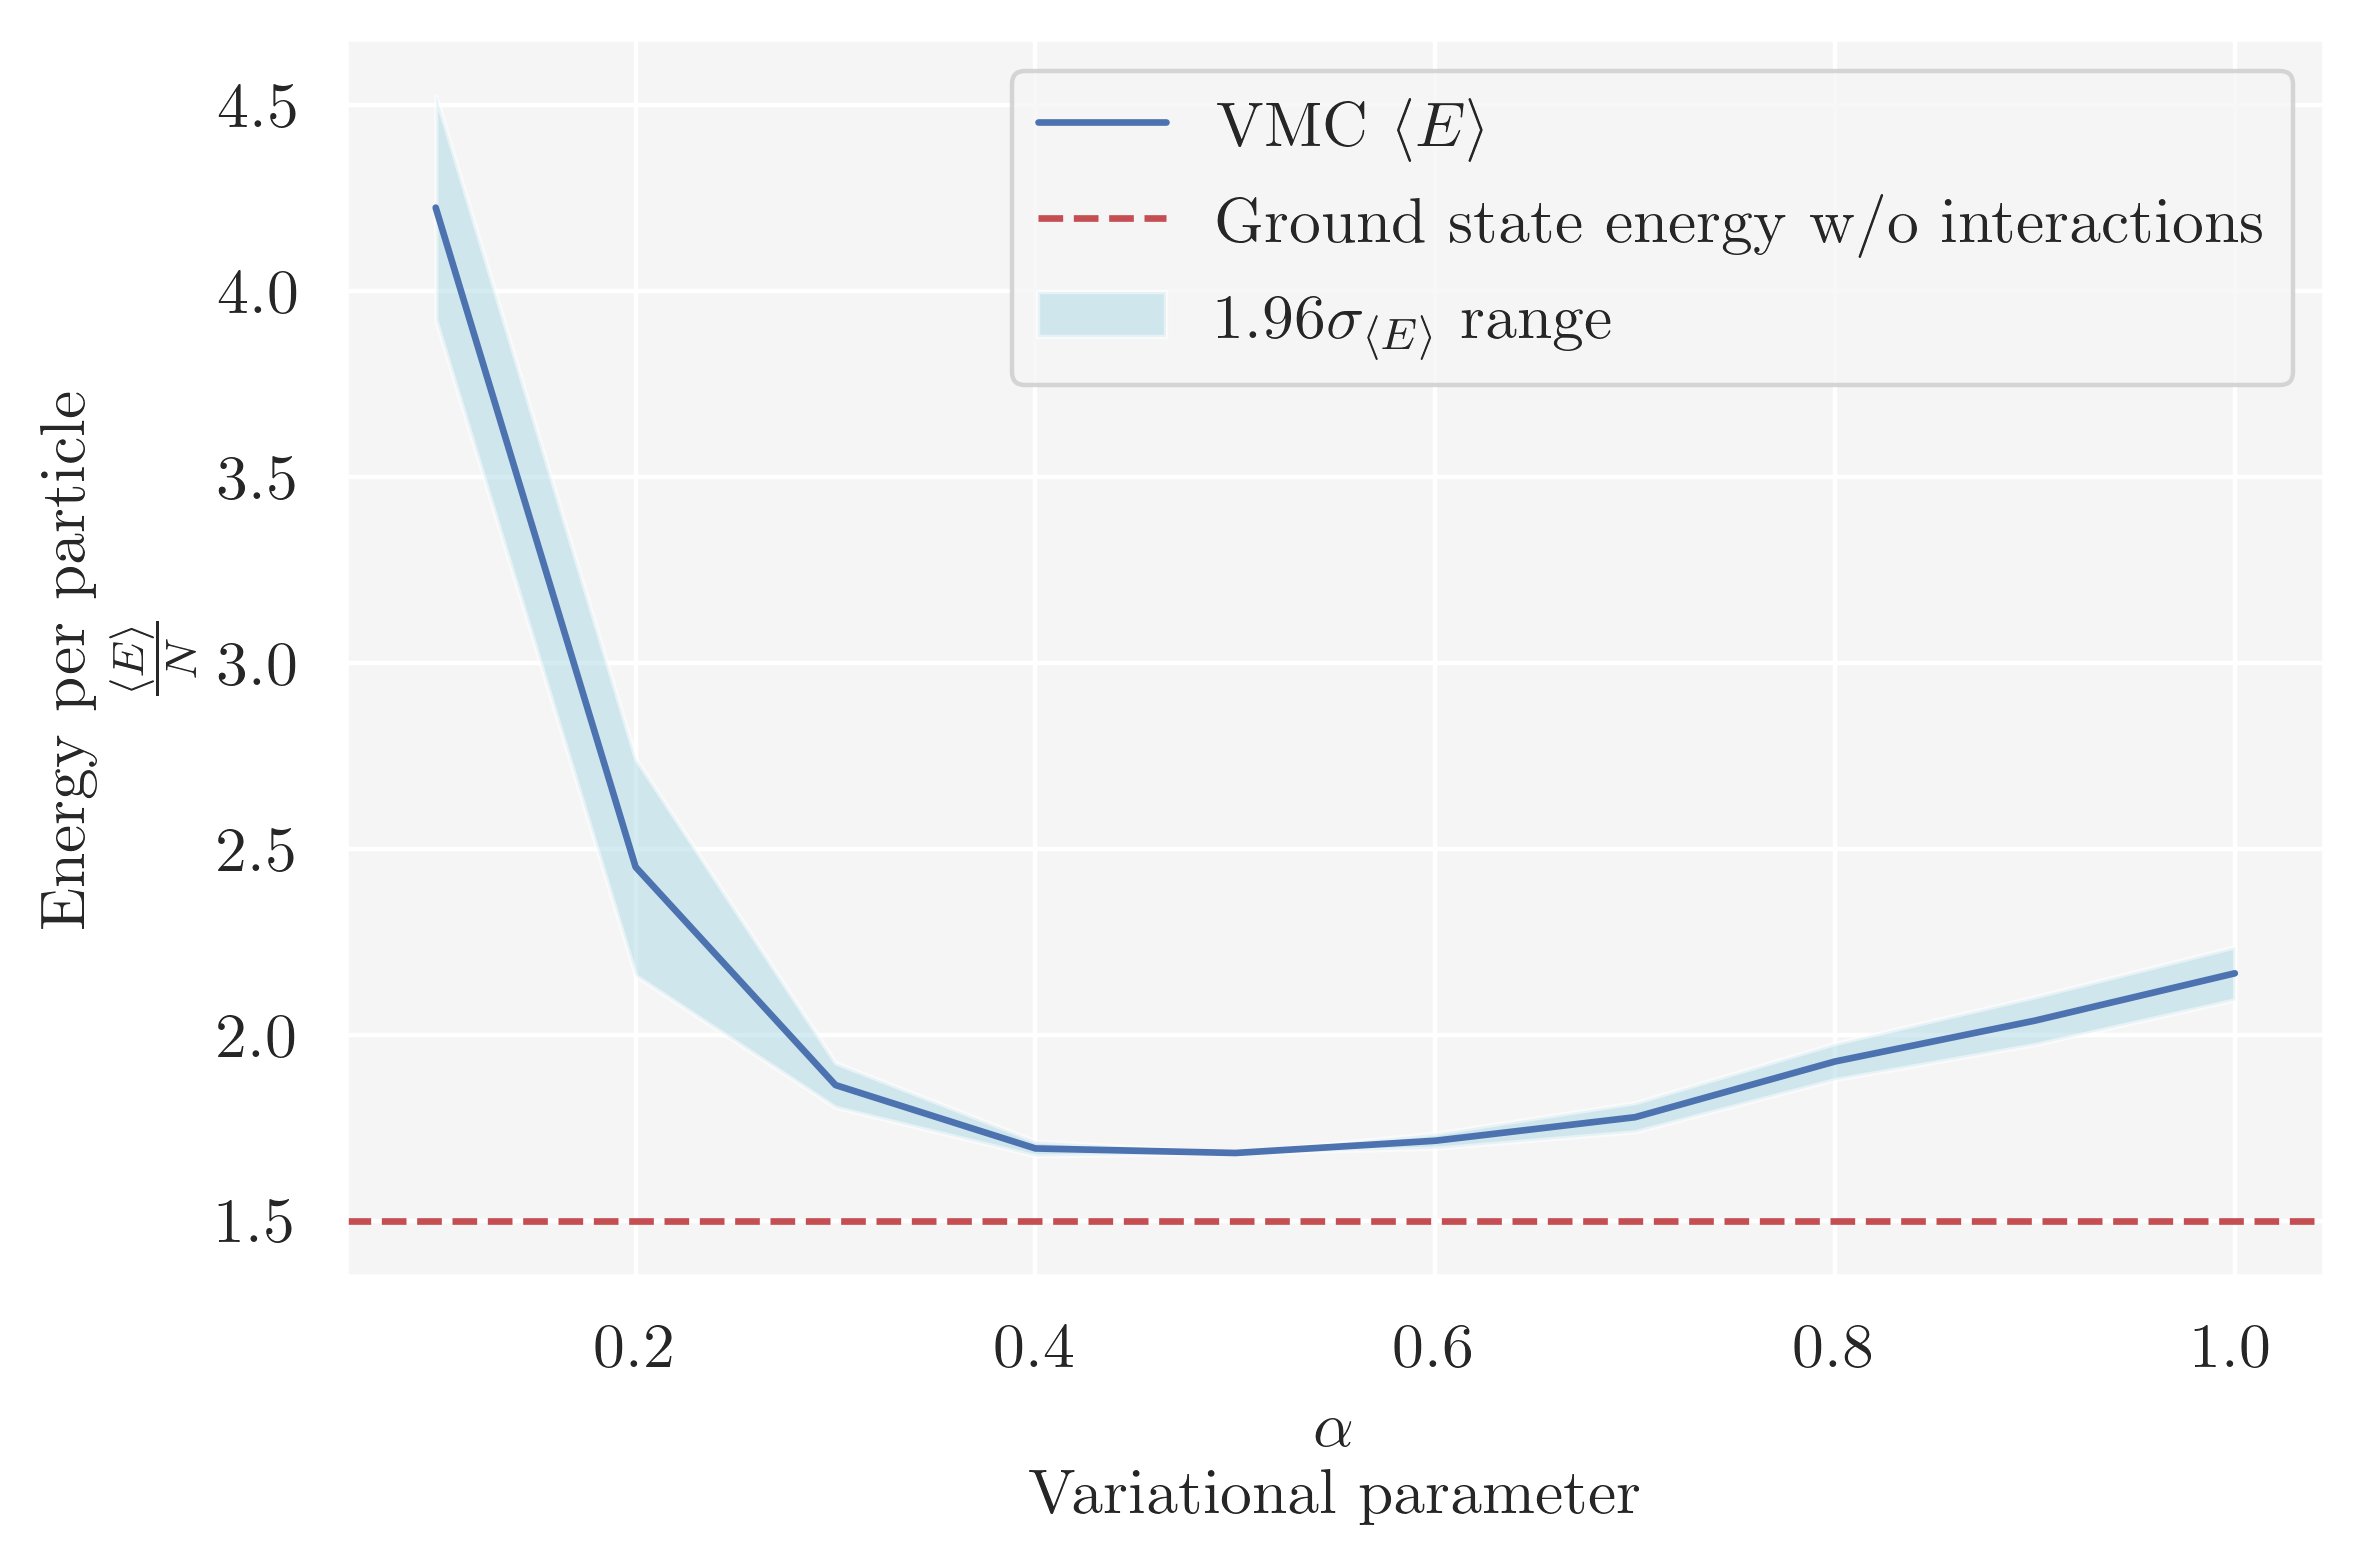

In [36]:
lower_bound_N100 = df_means_N100["energy"] - 1.96*df_means_N100["standard_error"]
upper_bound_N100 = df_means_N100["energy"] + 1.96*df_means_N100["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_N100, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_N100["alpha"], lower_bound_N100, upper_bound_N100, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_50.pdf"), bbox_inches='tight')

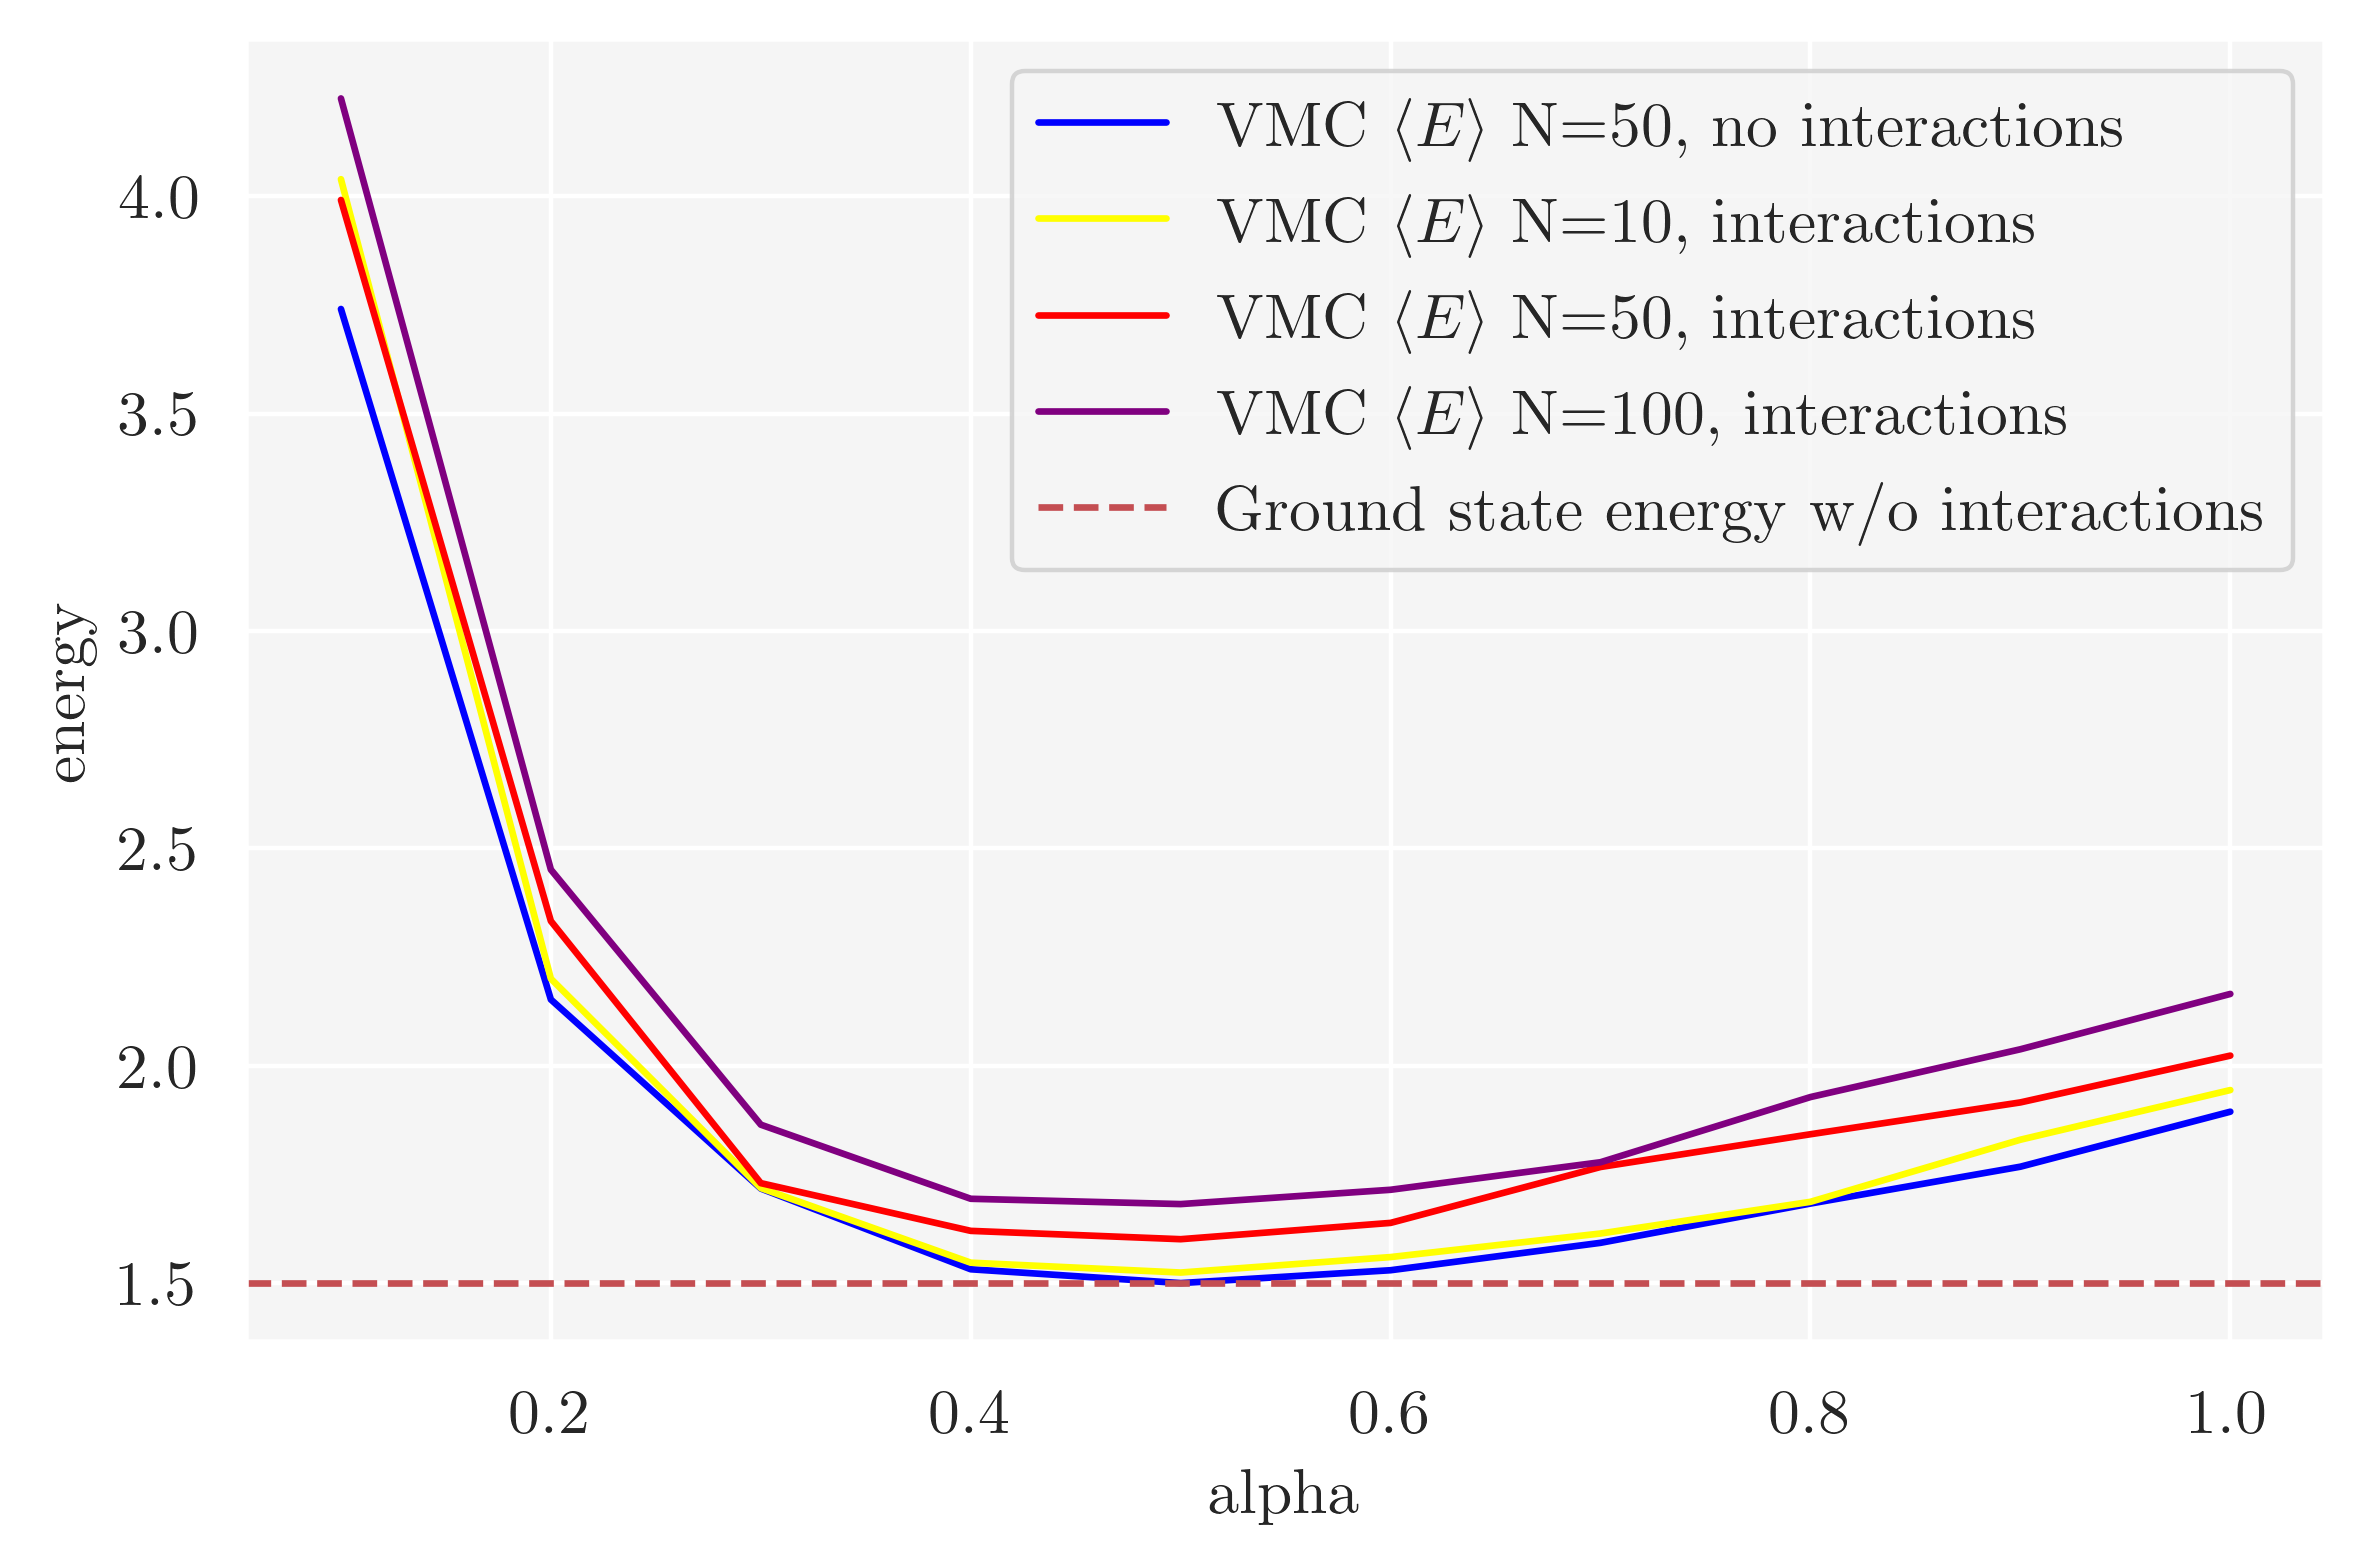

In [48]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True, dpi=200)
no_int_label = '\n'.join((r'VMC $\langle E\rangle$ N=50',
                         'No interactions'))
label_sigma_no_int = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '50 non-interacting particles'))
label_sigma_10 = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '10 interacting particles'))
label_sigma_50 = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '50 interacting particles'))
label_sigma_100 = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '100 interacting particles'))
sns.lineplot(data=df_means_NI_N50, x="alpha", y="energy", ax=ax, color="blue", label=r'VMC $\langle E\rangle$ N=50, no interactions')
#ax.fill_between(df_means_NI_N50["alpha"], lower_bound, upper_bound, facecolor='lightblue', alpha=0.5)
               #label=label_sigma_no_int)
sns.lineplot(data=df_means_N10, x="alpha", y="energy", ax=ax, color="yellow", label=r'VMC $\langle E \rangle$ N=10, interactions')
#ax.fill_between(df_means_N10["alpha"], lower_bound_N10, upper_bound_N10, facecolor='gold', alpha=0.5)
                #label=label_sigma_10)
sns.lineplot(data=df_means_N50, x="alpha", y="energy", ax=ax, color="red", label=r'VMC $\langle E\rangle$ N=50, interactions')
#ax.fill_between(df_means_N50["alpha"], lower_bound_N50, upper_bound_N50, facecolor='tomato', alpha=0.5)
                #label=label_sigma_50)
sns.lineplot(data=df_means_N100, x="alpha", y="energy", ax=ax, color="purple", label=r'VMC $\langle E\rangle$ N=100, interactions')
#ax.fill_between(df_means_N100["alpha"], lower_bound_N100, upper_bound_N100, facecolor='magenta', alpha=0.5)
                #label=label_sigma_100)
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_all_N.pdf"), bbox_inches='tight')